# Matching Morphologies and Synapses

In [1]:
import sys, os, json, pandas
import numpy as np

sys.path.append('../neural_network_dynamics/')
import nrn
from nrn.plot import nrnvyz

from meshparty import meshwork 

sys.path.append('..')
import plot_tools as pt
import matplotlib.pylab as plt

In [2]:
def load(ID):
    """
    we translate everything in terms of skeleton indices ! (mesh properties)
    """
    
    ### --- MESHWORK file 1 (the one with the same coordinates than the swc file !)
    cell = meshwork.load_meshwork('../data/%s/%s.h5' % (ID, ID))

    ## --- METADATA file
    with open('../data/%s/%s_metadata.json' % (ID, ID)) as f:
        cell.infos = json.load(f)

    ## --- SWC file
    cell.morpho = nrn.Morphology.from_swc_file('../data/%s/%s.swc' % (ID, ID))
    cell.SEGMENTS = nrn.morpho_analysis.compute_segments(cell.morpho)
    cell.soma_coords = np.array([cell.SEGMENTS['x'][0],
                                 cell.SEGMENTS['y'][0],
                                 cell.SEGMENTS['z'][0]])
    

    ### --- MESHWORK file 2 (the one with the same coordinates than the synaptic locations !)
    mesh = meshwork.load_meshwork('../data/SchneiderMizell_et_al_2023/skeletons/meshwork/%s.h5' % (ID.split('_')[0]))
    
    synapses = mesh.vertices[mesh.anno['post_syn']['mesh_ind']]
    synapses = (synapses-cell.infos['soma_location'])/1e3+\
                    1e6*cell.soma_coords

    # 1) splitting axon and dendrites !
    axon_inds, Q = meshwork.algorithms.split_axon_by_annotation(mesh, 
                                                                pre_anno='pre_syn',
                                                                post_anno='post_syn')
    if Q<0.5:
        print(' /!\ axon splitting not trusted... /!\ ')
    mesh.axon_inds = mesh.skeleton.mesh_to_skel_map[axon_inds]
    mesh.is_axon = np.array([(m in mesh.axon_inds) for m in mesh.skeleton_indices], dtype=bool)
        
    # 2) get synapses:
    post_syn_sites = mesh.skeleton.mesh_to_skel_map[mesh.anno['post_syn']['mesh_ind']]
    
    # 3) add the synapses that belong to the dendrite !
    cell.synapses = np.array([synapses[i] for i, s in enumerate(post_syn_sites)\
                                 if s not in mesh.skeleton_indices[mesh.is_axon]])
    
    # 4) determine the mapping between synapses and morphologies
    cell.synapses_morpho_index = [np.argmin(distance(cell, i)) for i in range(len(cell.synapses))]
    # number of synapses per segments
    cell.SEGMENTS['Nsyn'] = np.histogram(cell.synapses_morpho_index,
                                 bins=np.arange(len(cell.SEGMENTS['x'])+1))[0]
    
    # 4) compute the path distance to soma
    cell.syn_dist_to_soma = [cell.skeleton.distance_to_root[p]/1_000 for p in post_syn_sites]
    
    return cell

def distance(cell, syn_index):
    return (1e6*cell.SEGMENTS['x']-cell.synapses[syn_index,0])**2+\
            (1e6*cell.SEGMENTS['y']-cell.synapses[syn_index,1])**2+\
            (1e6*cell.SEGMENTS['z']-cell.synapses[syn_index,2])**2

cell = load('864691137053906294_301107')

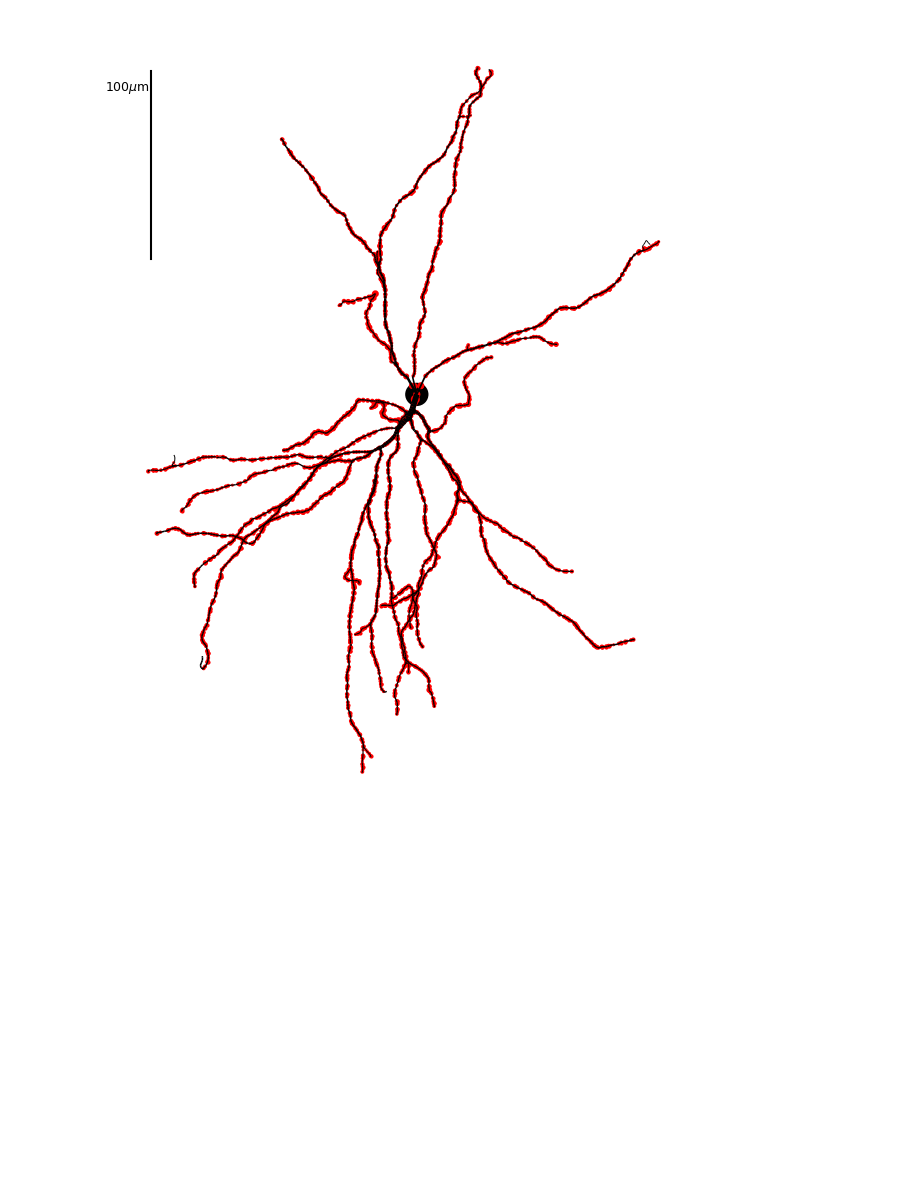

In [5]:
fig, ax = plt.subplots(1, figsize=(10,10))

vis = nrnvyz(cell.SEGMENTS)
vis.plot_segments(cond=(cell.SEGMENTS['comp_type']!='axon'),
                  bar_scale_args={'Ybar':100, 'Xbar':1e-9,
                                  'Ybar_label':'100$\mu$m ', 'fontsize':6}, ax=ax)
ax.scatter(1e6*cell.SEGMENTS['x'][cell.synapses_morpho_index][::10],
           1e6*cell.SEGMENTS['y'][cell.synapses_morpho_index][::10],
           color='r', s=1, alpha=1)
ax.scatter(1e6*cell.SEGMENTS['x'],
           1e6*cell.SEGMENTS['y'],
           s = .2*cell.SEGMENTS['Nsyn'],
           color='r', alpha=1)

#vis.add_dots(ax,
#             range(len(cell.SEGMENTS['x'])), cell.SEGMENTS['Nsyn']/5)